# Project 1

### *Ifigeneia Giannakoudi*

Let us begin with presenting the goal o this project. We are given a set of data, which contain measurements of a quantity x, a quantity y and their measurement errors. We want to find the relation between the quantities x and y, by finding the optimum fitting among these data points. We will assume that only the 'y' qunatity has error 'sigma_y' and that 'x' is flawlessly measured. 



First, we are going to insert the data file, with which we are going to work.

In [1]:
] add CSV

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
] add DataFrames

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [3]:
import Pkg; Pkg.add("ColorSchemes")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [4]:
using CSV
using DataFrames

In [5]:
alldata = CSV.read("data1.csv", DataFrame); 

In [6]:
size(alldata)

(20, 6)

Let's plot our data points to see what they look like.

In [7]:
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(alldata.x, alldata.y, alldata.sigma_y)
scatter!(alldata.x, alldata.y, markersize=17, color=:orange) 
f

LoadError: UndefVarError: Figure not defined

We will work with a subest of our data, we will exclude the first 5 points because they mess up the fitting. 

In [8]:
data = alldata[5:end, :]; #to take the subset of the data that we want to work with

In [9]:
size(data)

(16, 6)

In [10]:
# our 'x' measurements which we will assume are perfectly measured, without error
data.x 

16-element Vector{Int64}:
 203
  58
 210
 202
 198
 158
 165
 201
 157
 131
 166
 160
 186
 125
 218
 146

In [11]:
using WGLMakie

Let's plot our data points (x,y) and add the errorbars of 'y' to see how the look like.

In [12]:
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=17, color=:violet)
f

#### **1. A higher-order fit.  We did a linear fit (y_pred = b + m x).  Try extending the code to do a quadratic fit: y_pred = b + m x + q x^2. Does the fit improve?  Repeat the jack-knife analysis (and plot up the answers produced by each run of the jack-knife), and investigate the scatter in the "q" values.  Can you conclude anything about whether you need the "q" term for a good fit?**

Now, instead of the linear fit we did in class , we are going to try a quadratic fit in our data points. 

So our prediction of y will look like: **y_pred = b + m*x + q*x^2**

In [13]:
# Just by looking at the plot, we will assume that:
m_eye = 2.125
b_eye = 50
q_eye = 0.00025

0.00025

In [14]:
xx = LinRange(50, 250, 20)

20-element LinRange{Float64, Int64}:
 50.0,60.5263,71.0526,81.5789,92.1053,…,207.895,218.421,228.947,239.474,250.0

Next, we plot our data points and add our predicted curve.

In [15]:
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:violet) 
yy_eye = q_eye.*xx.^2 .+ xx .* m_eye .+ b_eye
lines!(xx, yy_eye, color=:green)
f

The prediction seems pretty good, but let's do it in a more proper way than just guessing by the eye.

For this purpose we need an optimizer. To use it, we first need an objective function that will take our parameters as arguments and return a scalar, which essentially encludes the comparison of the predicted value for y, 'y_pred', with the measured one, 'y'. This is the function that we will "feed" to our optimizer and the latter will look for the best values of our parameter space that minimize the 'comparison' scalar. 

In [16]:
] add Optim

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [17]:
using Optim

The first obective function that we will use is just the sum the absolute difference between b,m and q with some values we want them to take, e.g. 3, 50 and 0.0001

In [18]:
function objective_abs(parameters)
    b = parameters[1]
    m = parameters[2]
    q = parameters[3]
    
    return abs(b - 25) + abs(m - 2) + abs(q - 0.0001) #with what criterion we chose these?
end

objective_abs (generic function with 1 method)

Next, we are going to use the optimize function, which will perform some steps towards finding the optimum values for (b,m,q) that minimize the outcome of our objective function. 

In [19]:
starting_params_abs = [b_eye + 0., m_eye, q_eye] #+0. was a trick to turn it into a float
result = optimize(objective_abs, starting_params_abs)

 * Status: success

 * Candidate solution
    Final objective value:     3.446403e-03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    183
    f(x) calls:    349


In [20]:
# The values of (b,m,q) that the optimizer found
b_abs , m_abs, q_abs = Optim.minimizer(result)

3-element Vector{Float64}:
 25.001415626049198
  2.0020307556106984
  0.00010002136156695504

We plot the fit with the parameter values given by the optimizer (blue) line.

In [21]:
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:violet) 
yy_eye = xx .* m_eye .+ b_eye .+ q_eye.*xx.^2
lines!(xx, yy_eye, color=:green)

yy_abs = xx .*m_abs .+ b_abs .+ q_abs.*xx.^2
lines!(xx, yy_abs, color=:blue)

f

Let us proceed my defining a different objective function, comparing the sum of the absolute differences of the predicted and measured y's for all of our x's.

In [22]:
function objective_2(parameters)
    b = parameters[1]
    m = parameters[2]
    q = parameters[3]
    
    y_pred = b .+ m .* data.x .+  q.* data.x.^2
    
    return sum(abs.(data.y .- y_pred))
end

objective_2 (generic function with 1 method)

In [23]:
starting_params = [b_eye + 0., m_eye, q_eye] 
result = optimize(objective_2, starting_params)

 * Status: success

 * Candidate solution
    Final objective value:     3.339365e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    192
    f(x) calls:    356


In [24]:
# these are the optimum values of (b,m,q) that minimize our objective function
b_2 , m_2, q_2  = Optim.minimizer(result)

3-element Vector{Float64}:
 94.76027385200408
  1.109234768513572
  0.004133207360921443

Let us also plot the fit for curve for these values for (b,m,q). This is the red line.

In [25]:
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:violet) 
yy_eye = xx .* m_eye .+ b_eye .+ q_eye.*xx.^2
lines!(xx, yy_eye, color=:green)

yy_abs = xx .*m_abs .+ b_abs .+ q_abs.*xx.^2
lines!(xx, yy_abs, color=:blue)

yy_2 = xx .*m_2 .+ b_2 .+ q_2.*xx.^2
lines!(xx, yy_2, color=:red)

f

Now, we will use a Gaussian distribution as objective function. Imagine a gaussian distribution with mean our measured 'y' and standard deviation the 'sigma_y'. Then the predicted y, 'y_pred' will lie somewhere in this distribution and correspond to probability density f(y_pred). We want to find these values for (b,m,q) for which the 'y_pred''s are the clsetst to the mean of the distributions for as many 'y_pred''s as possible. In essence, minimize the deviation from the measured value considering all the 'y's.

Instead of working with the product of the gaussian likelihoods, we will work with the sum of their logs.

In [26]:
function objective_g(params, x, y, sigma)
    b = params[1]
    m = params[2]
    q = params[3]
    y_pred = b .+ m .* x .+ q .* x.^2
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end

objective_g (generic function with 1 method)

In [27]:
starting_params = [b_eye, m_eye, q_eye]
result = optimize(p -> objective_g(p, data.x, data.y, data.sigma_y),
                  starting_params)

 * Status: success

 * Candidate solution
    Final objective value:     1.044006e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    95
    f(x) calls:    175


In [28]:
@assert Optim.converged(result)
b_g , m_g, q_g  = Optim.minimizer(result)

3-element Vector{Float64}:
 101.52188730968251
   1.1120635521966622
   0.0037910373646556778

In [29]:
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:violet)
yy_eye = xx .* m_eye .+ b_eye .+ q_eye.*xx.^2
lines!(xx, yy_eye, color=:green)

yy_abs = xx .*m_abs .+ b_abs .+ q_abs.*xx.^2
lines!(xx, yy_abs, color=:blue)

yy_2 = xx .*m_2 .+ b_2 .+ q_2.*xx.^2
lines!(xx, yy_2, color=:red)

yy_g = xx .*m_g .+ b_g .+ q_g.*xx.^2
lines!(xx, yy_2, color=:gray)

f

Interestingly we see that the Gaussian optimization concides with the optimization of the absolute values.  

In [30]:
data.x[1:end];

In [31]:
ndata = size(data.x,1)

16

Now we will repeat a jack-knife process to determine the values of (b,m,q). What we do essentially is that we exclude one point at a time from out data set and call the optimizer to find the values of (b,m,q) that minimize our objective function, we store these values in 3 arrays (vectors) and repeat the process for the next point. 

In [32]:
B_jack = zeros(ndata)
M_jack = zeros(ndata)
Q_jack = zeros(ndata)
for i in 1:ndata
    xcopy = copy(data.x)
    deleteat!(xcopy, i)
    ycopy = copy(data.y)
    deleteat!(ycopy, i)
    scopy = copy(data.sigma_y)
    deleteat!(scopy, i)
    starting_params = [b_eye + 0., m_eye, 0.]
    result = optimize(p -> objective_g(p, xcopy, ycopy, scopy),
                      starting_params)
    
    b_jack, m_jack, q_jack = Optim.minimizer(result)    
    B_jack[i] = b_jack
    M_jack[i] = m_jack
    Q_jack[i] = q_jack
end

Here, we plot the predicted curves we found through the jack-knife process.

In [33]:
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:violet) 

for i in 1:ndata
    yy_jack = xx.^2 .* Q_jack[i] .+ xx .* M_jack[i] .+ B_jack[i]
    lines!(xx , yy_jack, color=:red, linewidth=1)
end

yy_g = xx .*m_g .+ b_g .+ q_g.*xx.^2
lines!(xx, yy_2, color=:blue, linewidth=2)

f

By investigating the values of the parameters (b,m,q) in the planes (b,m) , (b,q) , (m,q) we observe that the values of q are generally very small, <<1. Thus, we conclude that the quadratic term is not nessecarilly needed for a good fit. 

In [34]:
f = Figure()
Axis(f[1,1],xlabel = "b_jack", ylabel = "m_jack")
scatter!(B_jack, M_jack, Q_jack, markersize=10, color=:blue) 

f

In [35]:
f = Figure()
Axis(f[1,1],xlabel = "b_jack", ylabel = "q_jack")
scatter!(B_jack, Q_jack, markersize=15, color=:red) 

f

In [36]:
f = Figure()
Axis(f[1,1],xlabel = "m_jack", ylabel = "q_jack")
scatter!(M_jack, Q_jack, markersize=15, color=:green) 

f

We can also find the mean values of (b,m,q) that the jack-knife process generated, as well as the standard deviation and plot the corresponding curves:

y = (b ± σ_b) + (m ± σ_m)x + (q ± σ_q)x^2

In [37]:
using Statistics

In [38]:
b_j= mean(B_jack) 
sigma_b = std(B_jack).*sqrt((ndata - 1)/ndata);

In [39]:
m_j = mean(M_jack) 
sigma_m = std(M_jack).*sqrt((ndata - 1)/ndata);

In [40]:
q_j = mean(Q_jack) 
sigma_q = std(Q_jack).*sqrt((ndata - 1)/ndata);

In [41]:
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(data.x, data.y, data.sigma_y)
scatter!(data.x, data.y, markersize=20, color=:violet) 

yy_m = xx .*m_j .+ b_j .+ q_j.*xx.^2
yy_b1 = xx .*m_j .+ b_j .+ sigma_b .+ q_j.*xx.^2
yy_b2 = xx .*m_j .+ b_j .- sigma_b .+ q_j.*xx.^2
yy_m1 = xx .*(m_j .+ sigma_m) .+ b_j .+ q_j.*xx.^2
yy_m2 = xx .*(m_j .- sigma_m) .+ b_j .+ q_j.*xx.^2
yy_q1= xx .*m_j .+ b_j .+ (q_j .+ sigma_q).*xx.^2
yy_q2= xx .*m_j .+ b_j .+ (q_j .- sigma_q).*xx.^2

lines!(xx, yy_m, color=:orange, linewidth=2)
lines!(xx, yy_b1, color=:dodgerblue2, linewidth=2)
lines!(xx, yy_b2, color=:dodgerblue2, linewidth=2)
lines!(xx, yy_m1, color=:indigo, linewidth=2)
lines!(xx, yy_m2, color=:indigo, linewidth=2)
lines!(xx, yy_q1, color=:violetred1, linewidth=2)
lines!(xx, yy_q2, color=:violetred1, linewidth=2)

f

#### **2. Investigate the m,b plane.  In class we plotted up our solutions in the m,b coordinate plane.  Here, I'd like you to investigate a bit more.  Try making a contour plots of the (Gaussian) objective function (in terms of m,b), but giving it only a single data point.  (I think you should find that there is a diagonal locus of m,b values that have a maximum log-likelihood (so minimum objective-function value), because those lines go right through that single data point.  Now try the same thing with a different data point.  (Plot both contours on the same plot.  Then also try plotting the contour for the two data points combined.)  Now try all data points.**

We will return back to the linear prediction: **y_pred = b + m*x** 

Let's plot the solutions of the Jack-knife process in this case in the (m,b) plane, as we did in class to remind ourselves of them. 

In [42]:
# we redefine the Gauss objective function
function objective_g(params, x, y, sigma)
    b = params[1]
    m = params[2]
 
    y_pred = b .+ m .* x 
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end

objective_g (generic function with 1 method)

In [43]:
starting_params = [b_eye, m_eye]
result = optimize(p -> objective_g(p, data.x, data.y, data.sigma_y),
                  starting_params)

 * Status: success

 * Candidate solution
    Final objective value:     1.044426e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    34
    f(x) calls:    69


In [44]:
# we repeat the Jack-knife process
ndata = size(data,1)

B_jack = zeros(ndata)
M_jack = zeros(ndata)

for i in 1:ndata
    
    xcopy = copy(data.x)
    deleteat!(xcopy, i)

    ycopy = copy(data.y)
    deleteat!(ycopy, i)

    scopy = copy(data.sigma_y)
    deleteat!(scopy, i)

    starting_params = [b_eye + 0., m_eye]
    result = optimize(p -> objective_g(p, xcopy, ycopy, scopy),
                      starting_params)
    @assert Optim.converged(result)
    b_jack, m_jack = Optim.minimizer(result)
    
    B_jack[i] = b_jack
    M_jack[i] = m_jack 
end

Let us plot the solutions in the (m,b) plane.

In [45]:
f = Figure()
Axis(f[1,1],xlabel = "b_jack", ylabel = "m_jack")
scatter!(B_jack, M_jack, markersize=10, color=:blue) 

f

We observe that they are more scattered than in the quadratic case, however in that case we have added an extra parameter. 

Let us make a contour plots of the Gaussian objective function in terms of m,b but giving it only a single data point, the point data.x[1], data.y[1]. 

In [46]:
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

og1 = [objective_g([b,m], data.x[1], data.y[1], data.sigma_y[1])
      for b in bvals, m in mvals]
f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
co1=contour!(bvals, mvals, og1, levels=20, colormap = ColorSchemes.ice.colors )
Colorbar(f[1, 2],co1)
f

LoadError: UndefVarError: ColorSchemes not defined

Let's repeat the same, but for a different point, the 8th one.

In [47]:
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

og8 = [objective_g([b,m], data.x[8], data.y[8], data.sigma_y[8])
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
co8=contour!(bvals, mvals, og8, levels=20, colormap = ColorSchemes.autumn1.colors)
Colorbar(f[1, 2],co8)
f



LoadError: UndefVarError: ColorSchemes not defined

Let's plot them in the same plot. We observe that the contours have have different inclinations, i.e the boundary lines of the contours intersect. 

In [48]:
using CairoMakie
using DelimitedFiles
using ColorSchemes

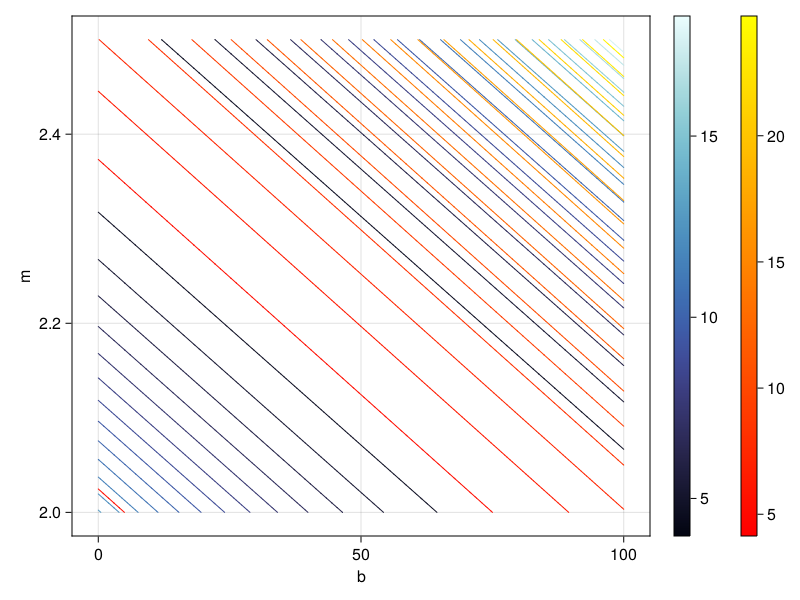

In [49]:
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
co1=contour!(bvals, mvals, og1, levels=20, colormap = ColorSchemes.ice.colors )
co8=contour!(bvals, mvals, og8, levels=20, colormap = ColorSchemes.autumn1.colors)
Colorbar(f[1, 2],co1)
Colorbar(f[1, 3],co8)

f

In [50]:
#to find color palettes: 
#julia> findcolorscheme("brown")

Now, let's plot the contour plot considering the two data points.

In [51]:
dx18= [data.x[1],data.x[8]]
dy18= [data.y[1],data.y[8]]
dsy18= [data.sigma_y[1],data.sigma_y[8]];


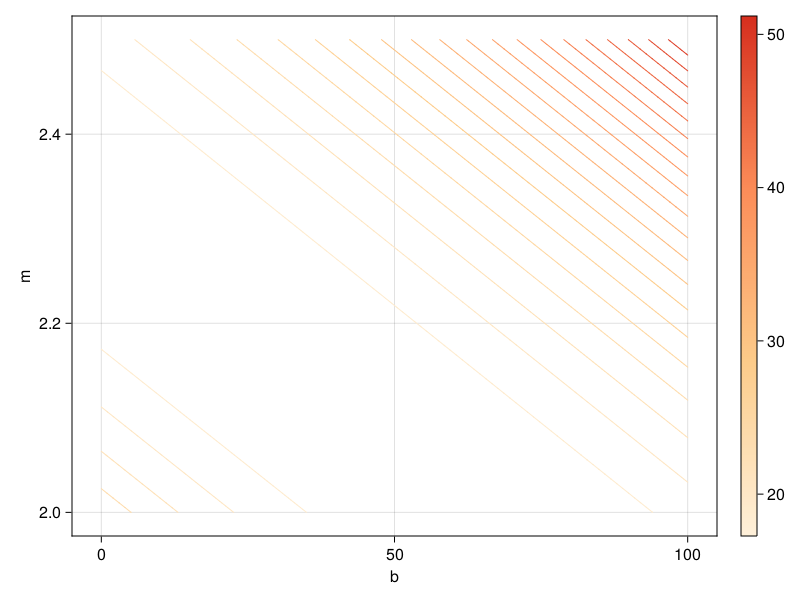

In [52]:
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

og18 = [objective_g([b,m], dx18, dy18, dsy18)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
call= contour!(bvals, mvals, og18, levels=20,colormap = ColorSchemes.OrRd_4.colors)
Colorbar(f[1, 2],call)
f

And all data points. One can see that as we add more points, the value of the objective function increases.

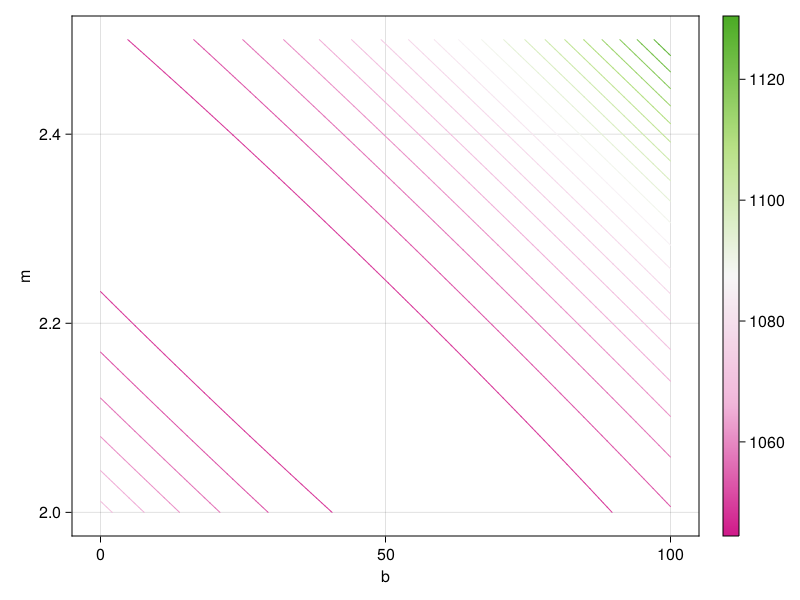

In [53]:
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

ogall = [objective_g([b,m], data.x, data.y, data.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
call= contour!(bvals, mvals, ogall, levels=20,colormap = ColorSchemes.PiYG_5.colors)
Colorbar(f[1, 2],call)
f

#### **Next, try plotting the contours for our outlier-rejecting version of the objective function.  Try expanding the range of the m and b parameters and see if you can find the "punk" minimum we found in class.  Are there other minima you can see also?**

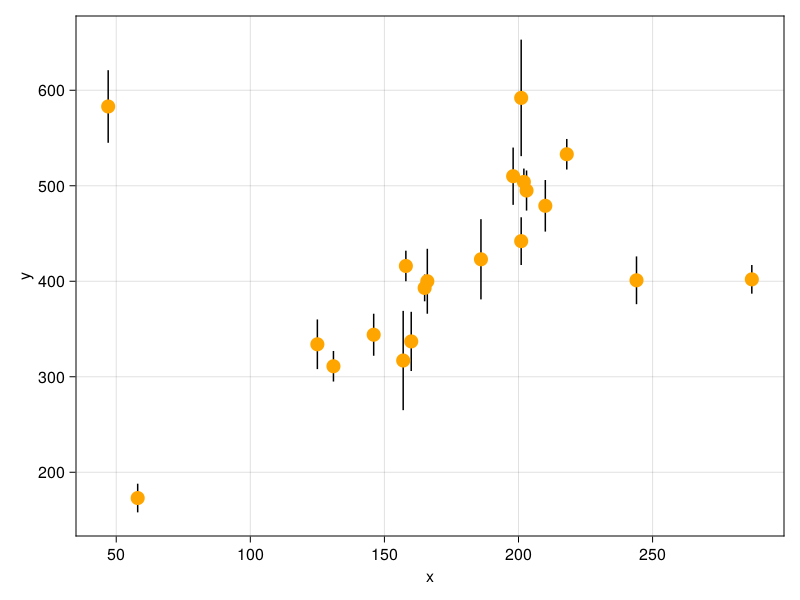

In [54]:
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(alldata.x, alldata.y, alldata.sigma_y)
scatter!(alldata.x, alldata.y, markersize=20, color=:orange)
f

Let us begin with some initial values for (b,m) we speculate with the eye.

In [55]:
starting_params = [b_eye + 0., m_eye]
result = optimize(p -> objective_g(p, alldata.x, alldata.y, alldata.sigma_y), starting_params)
    
    @assert Optim.converged(result)
    b_bad, m_bad = Optim.minimizer(result)

2-element Vector{Float64}:
 310.01703128739814
   0.6320100967887282

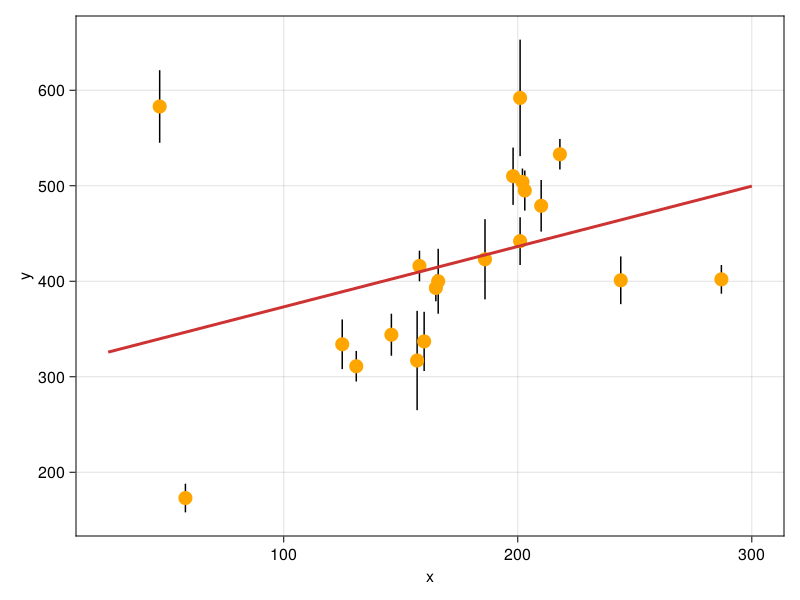

In [56]:
xxa = LinRange(25, 300, 20)
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(alldata.x, alldata.y, alldata.sigma_y)
scatter!(alldata.x, alldata.y, markersize=20, color=:orange) 


yy_bad = xxa .* m_bad .+ b_bad
lines!(xxa , yy_bad, color=:brown3, linewidth=3)

f

One can see that the values the optimizer gives off do not generate a very good overall fitting. Below we can also see the same for different starting parameters.

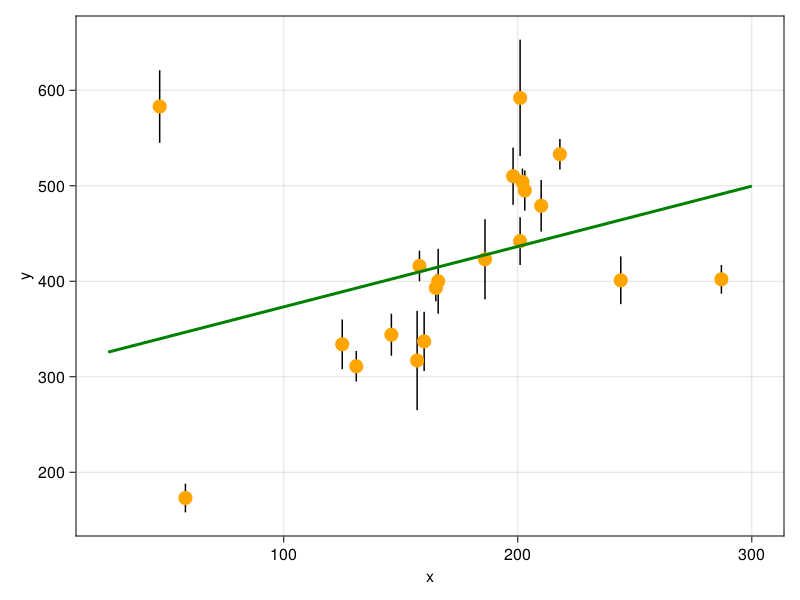

In [57]:
m_eyea = 1
b_eyea = 50

starting_params = [b_eyea + 0., m_eyea]
result = optimize(p -> objective_g(p, alldata.x, alldata.y, alldata.sigma_y), starting_params)
    
    @assert Optim.converged(result)
    b_bad1, m_bad1 = Optim.minimizer(result)

f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(alldata.x, alldata.y, alldata.sigma_y)
scatter!(alldata.x, alldata.y, markersize=20, color=:orange)

yy_bad = xxa .* m_bad1 .+ b_bad1
lines!(xxa , yy_bad, color=:green, linewidth=3)

f

Let us also plot the contour plots for two different intervals of starting parameters (b,m).

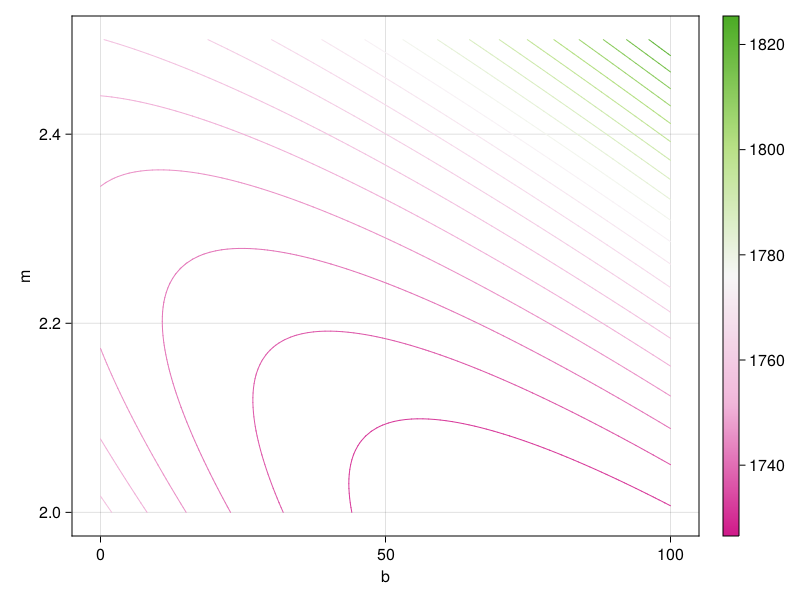

In [58]:
bvals = LinRange(0., 100., 100)
mvals = LinRange(2.0, 2.5, 100);

ogall = [objective_g([b,m], alldata.x, alldata.y, alldata.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
call= contour!(bvals, mvals, ogall, levels=20,colormap = ColorSchemes.PiYG_5.colors)
Colorbar(f[1, 2],call)
f

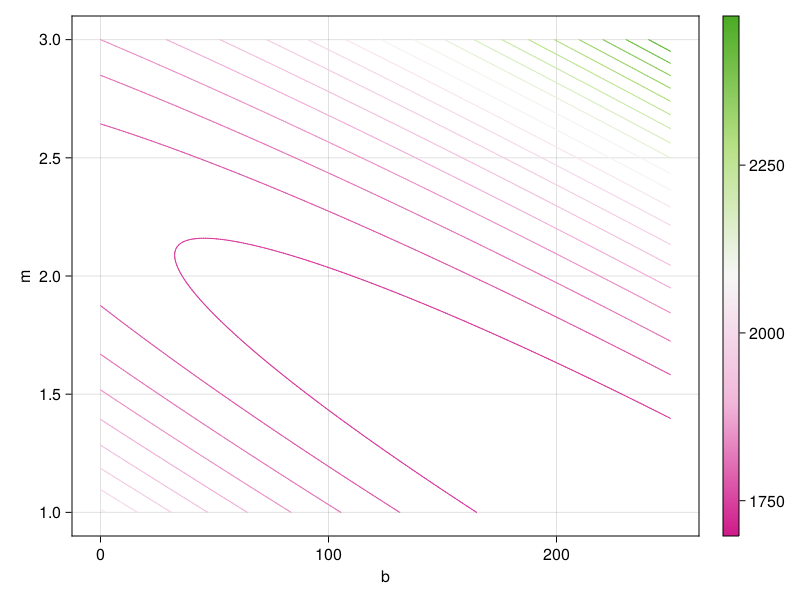

In [59]:
bvals = LinRange(0., 250., 300)
mvals = LinRange(1., 3., 300);

ogall = [objective_g([b,m], alldata.x, alldata.y, alldata.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
call= contour!(bvals, mvals, ogall, levels=20,colormap = ColorSchemes.PiYG_5.colors)
Colorbar(f[1, 2],call)
f

Now, we will assume that the results the optimizer gave us for minimization of the objective function that we used contribute as a small fraction in the overall process, i.e the objective function we defined is just one fraction of the whole likelihood function, hence the rest is 1-"the fraction that what we have contributes", and the overall likelyhood will be the 'bad' one we have so far and the good one that we will define below. 

In [60]:
function objective_outliers(parameters, x, y, sigma)
    b = parameters[1]
    m = parameters[2]

    frac_bad = 0.01
    like_bad = frac_bad * (1. / 500.)

    y_pred = b .+ m .* x
    like_good = (1. - frac_bad) * 1 ./(sqrt(2*π) .* sigma) .* exp.(-0.5 * (y .- y_pred).^2 ./ sigma.^2)
    like = like_bad .+ like_good
    loglike = log.(like)

    return -sum(loglike)
end

objective_outliers (generic function with 1 method)

In [61]:
starting_params = [b_eye + 0., m_eye]
result = optimize(p -> objective_outliers(p, alldata.x, alldata.y, alldata.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_good, m_good = Optim.minimizer(result)

2-element Vector{Float64}:
 32.72045146348233
  2.2526227271414627

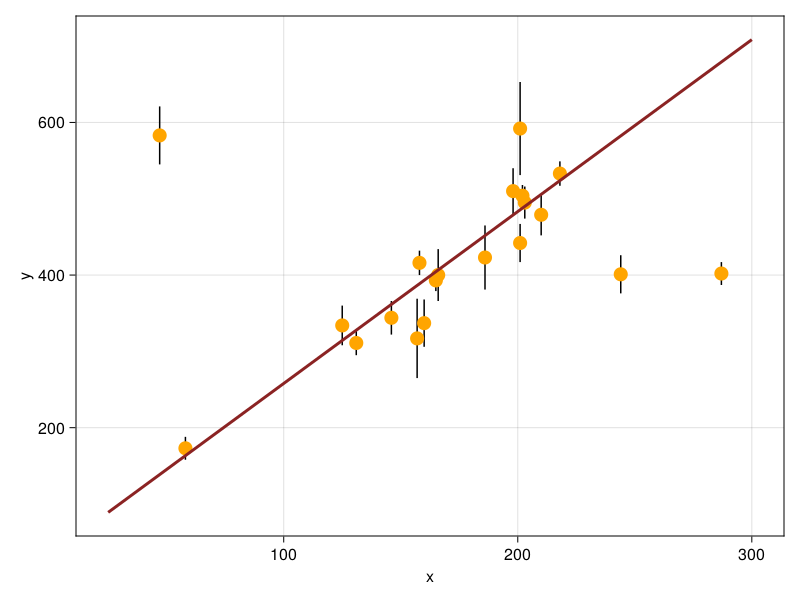

In [62]:
xxa = LinRange(25, 300, 20)
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(alldata.x, alldata.y, alldata.sigma_y)
scatter!(alldata.x, alldata.y, markersize=20, color=:orange)


yy_good = xxa .* m_good .+ b_good
lines!(xxa , yy_good, color=:brown4, linewidth=3)

f

As we already see, the fitting is much better than the first one! Let's construct the contour plot using this objective function. 

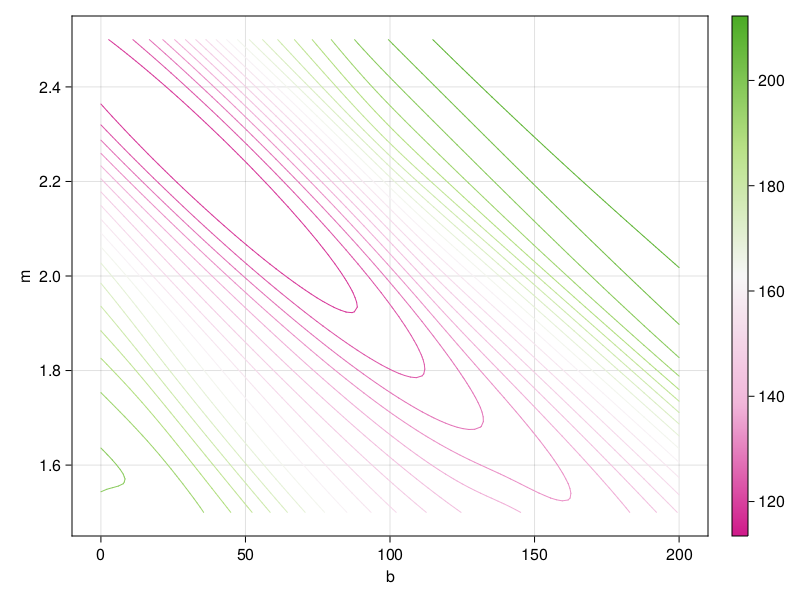

In [63]:
bvals = LinRange(0., 200., 100)
mvals = LinRange(1.5, 2.5, 100);

ogall = [objective_outliers([b,m], alldata.x, alldata.y, alldata.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
call= contour!(bvals, mvals, ogall, levels=20,colormap = ColorSchemes.PiYG_5.colors)
Colorbar(f[1, 2],call)
f

One can see that as we extend the ranges of (b,m) we come across other minima as well.

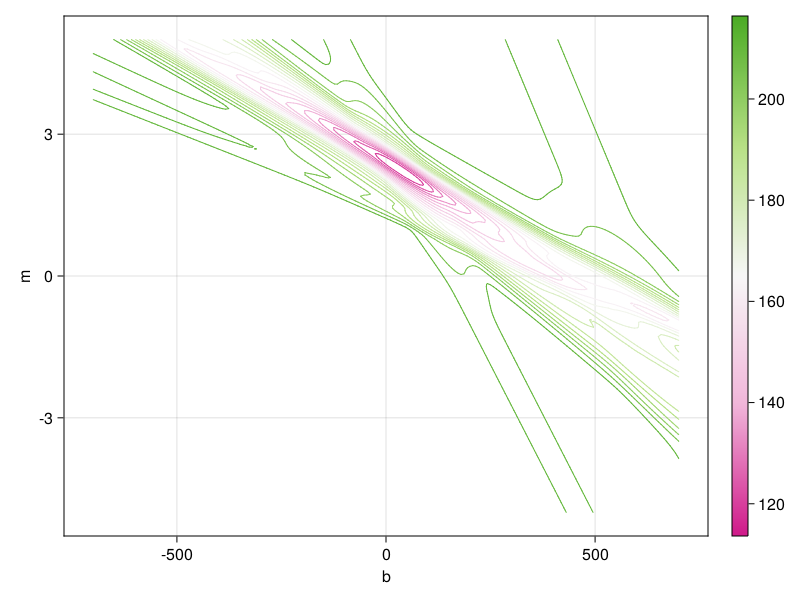

In [64]:
bvals = LinRange(-700, 700., 200)
mvals = LinRange(-5, 5, 200);

ogall = [objective_outliers([b,m], alldata.x, alldata.y, alldata.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
call= contour!(bvals, mvals, ogall, levels=20,colormap = ColorSchemes.PiYG_5.colors)
Colorbar(f[1, 2],call)
f

We can locate a punk minimum at roughly b=600 , m=-0.5. Let us use these as starting values in our optimizer and see what we get.

In [65]:
starting_params = [600 + 0.,-0.5]
result = optimize(p -> objective_outliers(p, alldata.x, alldata.y, alldata.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_p, m_p = Optim.minimizer(result)

2-element Vector{Float64}:
 629.4934013113243
  -0.7654463777444642

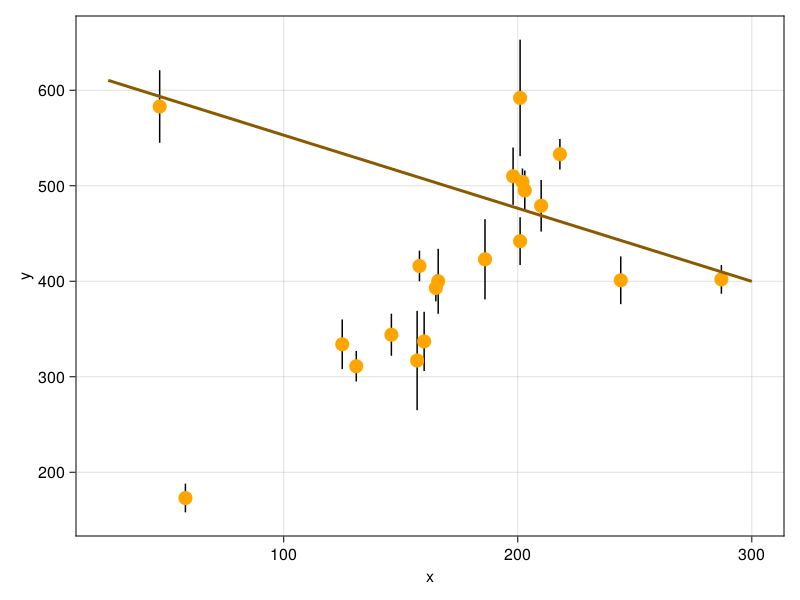

In [66]:
xxa = LinRange(25, 300, 20)
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(alldata.x, alldata.y, alldata.sigma_y)
scatter!(alldata.x, alldata.y, markersize=20, color=:orange)


yy_p = xxa .* m_p .+ b_p
lines!(xxa , yy_p, color=:orange4, linewidth=3)

f

From this plot we see that the fitting is not good at all, although it contains values for our parameters generated by our optimizer using the objective function we defined with starting parameters in a contour corresponding to a minimum of the function. This indicates that the optimizer just look for a pair values of (b,m) that minimize the value of our objective function based on some initial parameters to initiate the process, but minimization does not necessarily correspond to a good fit, as we see here. The starting points matter, so that we get values that correspond to finding values for our parameters that describe our dataset.

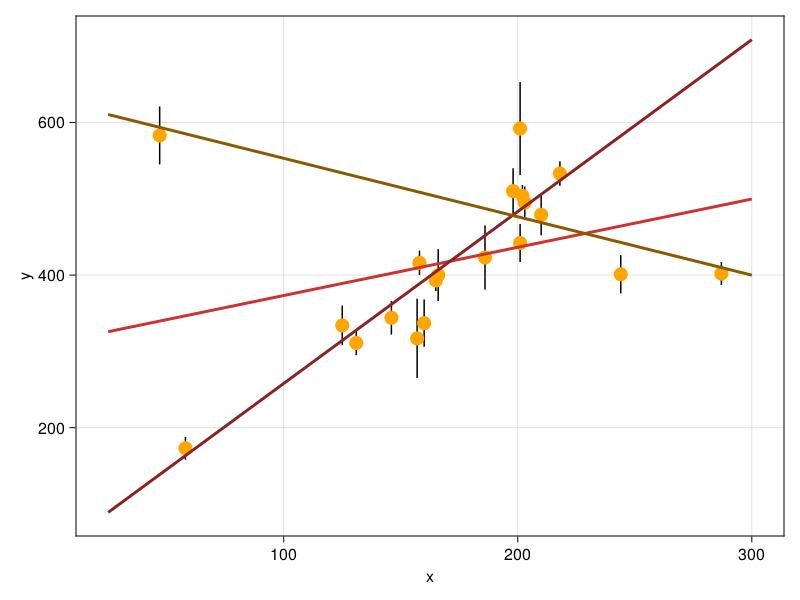

In [67]:
xxa = LinRange(25, 300, 20)
f = Figure()
Axis(f[1,1],xlabel = "x", ylabel = "y")
errorbars!(alldata.x, alldata.y, alldata.sigma_y)
scatter!(alldata.x, alldata.y, markersize=20, color=:orange)

lines!(xxa , yy_bad, color=:brown3, linewidth=3)
lines!(xxa , yy_good, color=:brown4, linewidth=3)
lines!(xxa , yy_p, color=:orange4, linewidth=3)

f

### **Stretch 2**

#### Record the m and b values that the optimize() function tries before it finds a minimum.  Plot those points over the contours (it'll probably be clearest to plot them with dots and lines connecting the dots).  Try starting it from different initial guesses.

In [68]:
# we redefine the Gauss objective function
function objective_g(params, x, y, sigma)
    b = params[1]
    m = params[2]
 
    y_pred = b .+ m .* x 
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end

objective_g (generic function with 1 method)

In [69]:
m_eye = 2.125
b_eye = 50;

In [70]:
M = Float64[]
B = Float64[]
function objective_gauss(parameters, x, y, sigma)
  b = parameters[1]
  m = parameters[2]
  push!(M, m)
  push!(B, b)
    y_pred = b .+ m .* x 
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end
# Convert from an array of Any to an array of Float64...
starting_params = [b_eye, m_eye]
result = optimize(p -> objective_gauss(p, data.x, data.y, data.sigma_y),
                  starting_params)

 * Status: success

 * Candidate solution
    Final objective value:     1.044426e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    34
    f(x) calls:    69


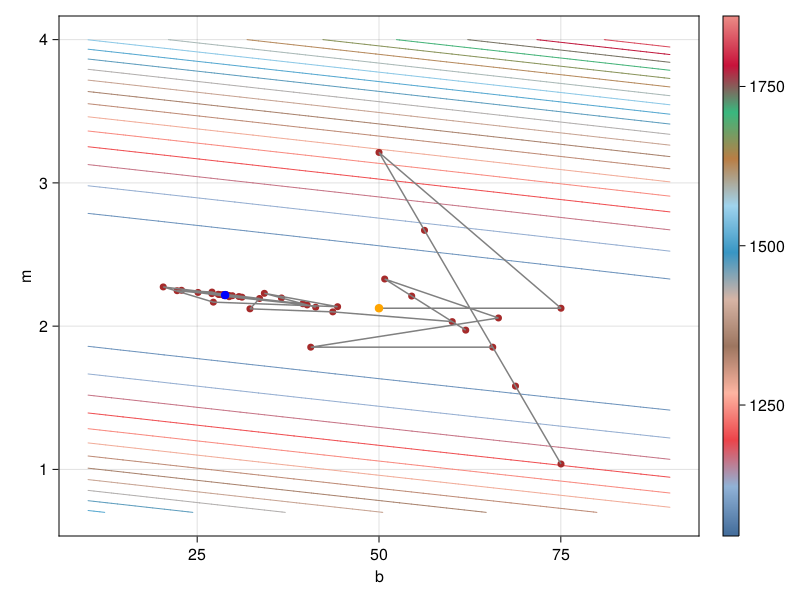

In [71]:
bvals = LinRange(10, 90., 100)
mvals = LinRange(0.7, 4, 100);

ogall = [objective_g([b,m], data.x, data.y, data.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
cs=contour!(bvals, mvals, ogall, levels=20,colormap = ColorSchemes.tableau_red_blue_brown.colors)
scatter!(B,M,markersize=10, color=:brown)
lines!(B, M, color=:grey)
scatter!(B[1],M[1], color=:orange)
scatter!(last(B),last(M),color=:blue)



Colorbar(f[1, 2],cs)
f

The same for different initial values

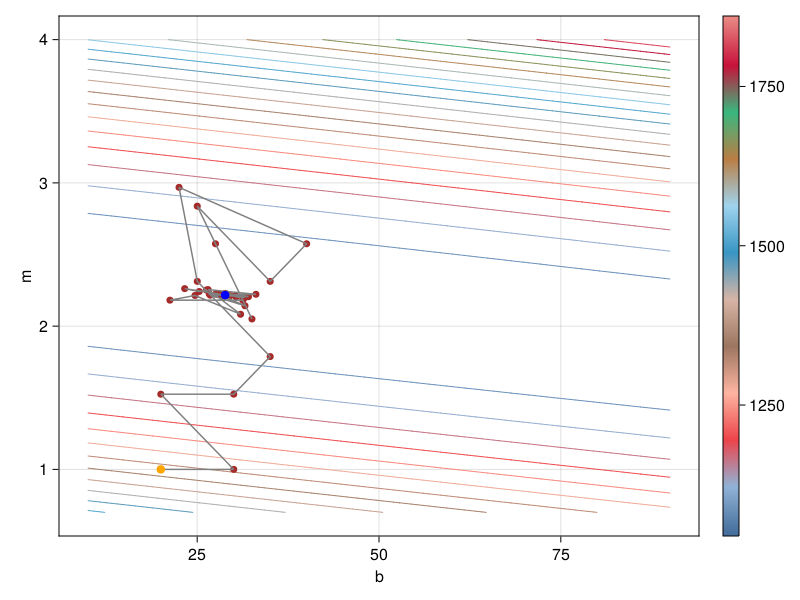

In [72]:
m_eye2 = 1.
b_eye2 = 20.;

M2 = Float64[]
B2 = Float64[]
function objective_gauss(parameters, x, y, sigma)
  b = parameters[1]
  m = parameters[2]
  push!(M2, m)
  push!(B2, b)
    y_pred = b .+ m .* x 
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end
# Convert from an array of Any to an array of Float64...
starting_params = [b_eye2, m_eye2]
result = optimize(p -> objective_gauss(p, data.x, data.y, data.sigma_y),
                  starting_params)

bvals = LinRange(10, 90., 100)
mvals = LinRange(0.7, 4, 100);

ogall2 = [objective_g([b,m], data.x, data.y, data.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
cs2=contour!(bvals, mvals, ogall, levels=20,colormap = ColorSchemes.tableau_red_blue_brown.colors)
scatter!(B2,M2,markersize=10, color=:brown)
lines!(B2, M2, color=:grey)
scatter!(B2[1],M2[1], color=:orange)
scatter!(last(B2),last(M2),color=:blue)


Colorbar(f[1, 2],cs2)
f

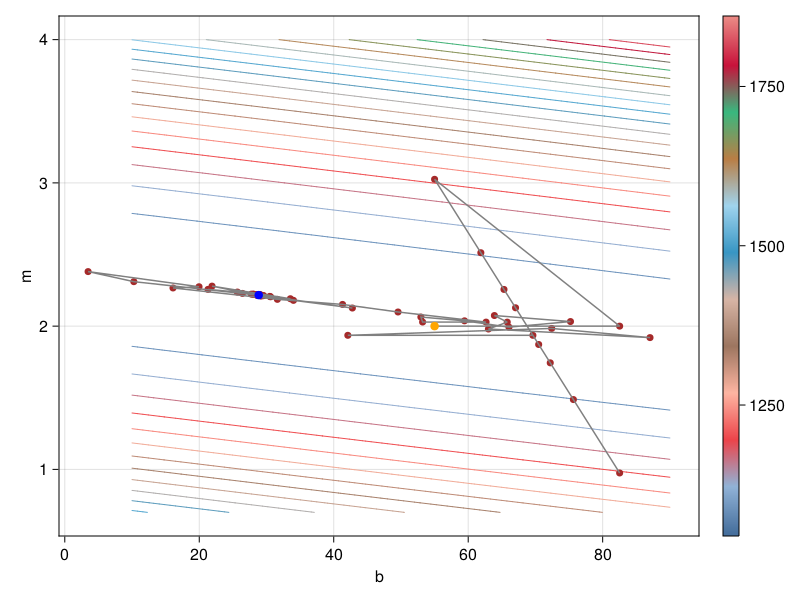

In [73]:
m_eye2 = 2.
b_eye2 = 55.;

M2 = Float64[]
B2 = Float64[]
function objective_gauss(parameters, x, y, sigma)
  b = parameters[1]
  m = parameters[2]
  push!(M2, m)
  push!(B2, b)
    y_pred = b .+ m .* x 
    return -sum(
        -log.(sigma * sqrt(2 * π)) .-0.5 .* (y .- y_pred).^2 / sigma.^2)
end
# Convert from an array of Any to an array of Float64...
starting_params = [b_eye2, m_eye2]
result = optimize(p -> objective_gauss(p, data.x, data.y, data.sigma_y),
                  starting_params)

bvals = LinRange(10, 90., 100)
mvals = LinRange(0.7, 4, 100);

ogall2 = [objective_g([b,m], data.x, data.y, data.sigma_y)
      for b in bvals, m in mvals]


f = Figure()
Axis(f[1, 1],xlabel = "b", ylabel = "m")
cs2=contour!(bvals, mvals, ogall, levels=20,colormap = ColorSchemes.tableau_red_blue_brown.colors)
scatter!(B2,M2,markersize=10, color=:brown)
lines!(B2, M2, color=:grey)
scatter!(B2[1],M2[1],color=:orange)
scatter!(last(B2),last(M2),color=:blue)

Colorbar(f[1, 2],cs2)
f

We see that given a different initial values (orange point), the optimizer follows a different, complicated "route" until it finds the optimum values for (b,m) (blue point).

#### **3. Remember that we found that our m,b estimates were anti-correlated. Can you rephrase or reparameterize the equation for a line so that the variables are less correlated?  First, you can try subtracting the average x value from all the x values, and find m',b' for that modified data set.  When you re-run the jack-knife test, does the covariance for the new m',b' values look better?  What happens if you try to convert your m',b' values back to m,b values for the original data set?**

We will use the Gaussian objective function we have been using so far.

In [74]:
starting_params = [b_eye + 0., m_eye]
mx = mean(data.x)
result = optimize(p -> objective_g(p, data.x .- mx, data.y, data.sigma_y),
                  starting_params)
@assert Optim.converged(result)
b_re, m_re = Optim.minimizer(result)
b_re = b_re - mx * m_re # y = mx + b = mx -m<x> + b = mx + b' , b' = -m<x> + b

28.843081468295054

We plot the (b,m) values we find through the jack-knife process. 

##### *before reparameterization*

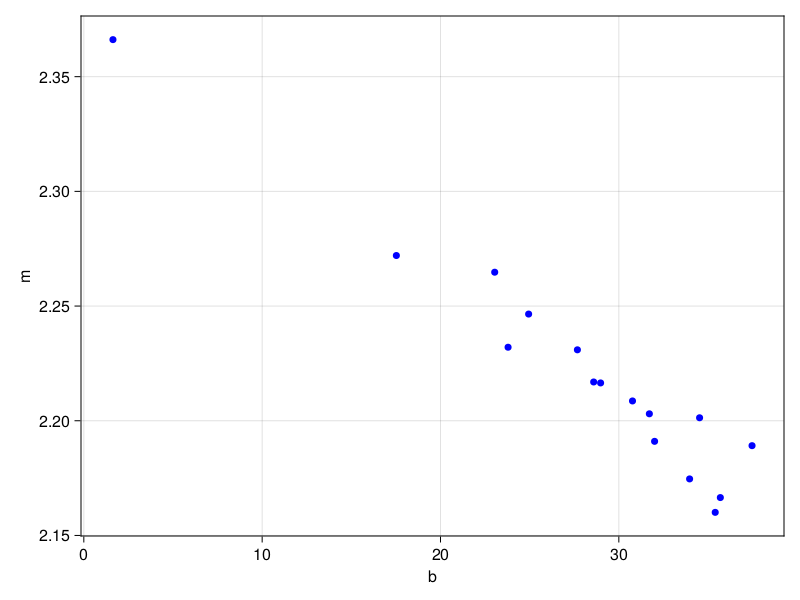

In [75]:
starting_params = [b_eye, m_eye]
result = optimize(p -> objective_g(p, data.x, data.y, data.sigma_y),
                  starting_params)

ndata = size(data,1)

B_jack = zeros(ndata)
M_jack = zeros(ndata)

for i in 1:ndata
    
    xcopy = copy(data.x)
    deleteat!(xcopy, i)

    ycopy = copy(data.y)
    deleteat!(ycopy, i)

    scopy = copy(data.sigma_y)
    deleteat!(scopy, i)

    starting_params = [b_eye + 0., m_eye]
    result = optimize(p -> objective_g(p, xcopy, ycopy, scopy),
                      starting_params)
    @assert Optim.converged(result)
    b_jack, m_jack = Optim.minimizer(result)
    
    
    B_jack[i] = b_jack
    M_jack[i] = m_jack 
end

f = Figure()
Axis(f[1,1],xlabel = "b", ylabel = "m")
scatter!(B_jack, M_jack, markersize=10, color=:blue) 

f

We observe that there can be an anti-correlation between them, which means there is some information to yet be extracted from the overall dataset. 

Let us 'reparametriaze' our set, i.e we will "redefine" 'x' to be 'x-mean(x)' .

##### *after reparameterization*

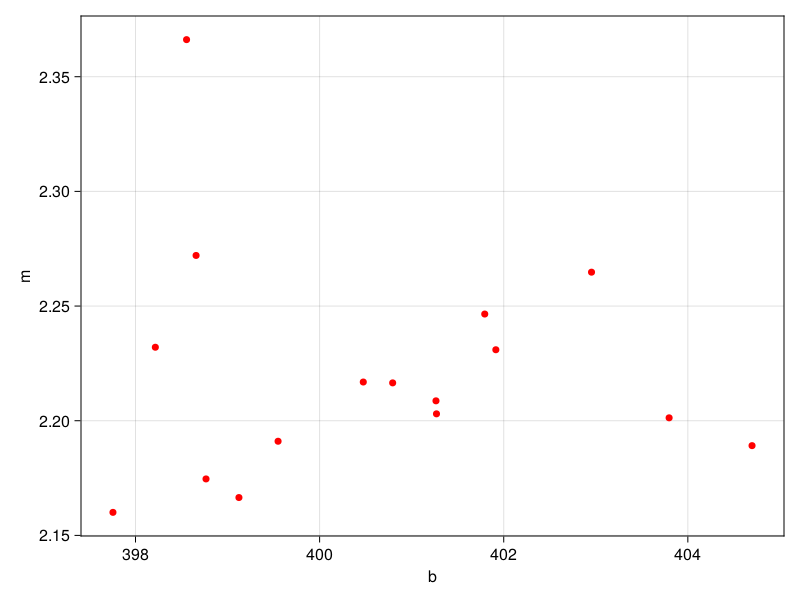

In [76]:
starting_params = [b_eye, m_eye]
result = optimize(p -> objective_g(p, data.x .- mean(data.x), data.y, data.sigma_y),
                  starting_params)

ndata = size(data,1)

B_jackr = zeros(ndata)
M_jackr = zeros(ndata)

for i in 1:ndata
    
    xcopyr = copy(data.x .- mean(data.x))
    deleteat!(xcopyr, i)

    ycopyr = copy(data.y)
    deleteat!(ycopyr, i)

    scopyr = copy(data.sigma_y)
    deleteat!(scopyr, i)

    starting_params = [b_eye + 0., m_eye]
    result = optimize(p -> objective_g(p, xcopyr, ycopyr, scopyr),
                      starting_params)
    @assert Optim.converged(result)
    b_jackr, m_jackr = Optim.minimizer(result)
    
    
    B_jackr[i] = b_jackr
    M_jackr[i] = m_jackr 
end

f = Figure()
Axis(f[1,1],xlabel = "b", ylabel = "m")
scatter!(B_jackr, M_jackr, markersize=10, color=:red) 

f

The values of (b,m) appear more scattered now and do not seem to be realted. 

If we try to convert them back to our original values, i.e set b-> b - m*mean(x), we fall on exaclty the same values of (b,m) before the reparametrization. That's expected since:

    before : y = b + m*x 
    
    after: y= b' + m*x' , with x' = x - mean(x)
    
    but b' = b - m*mean(x)

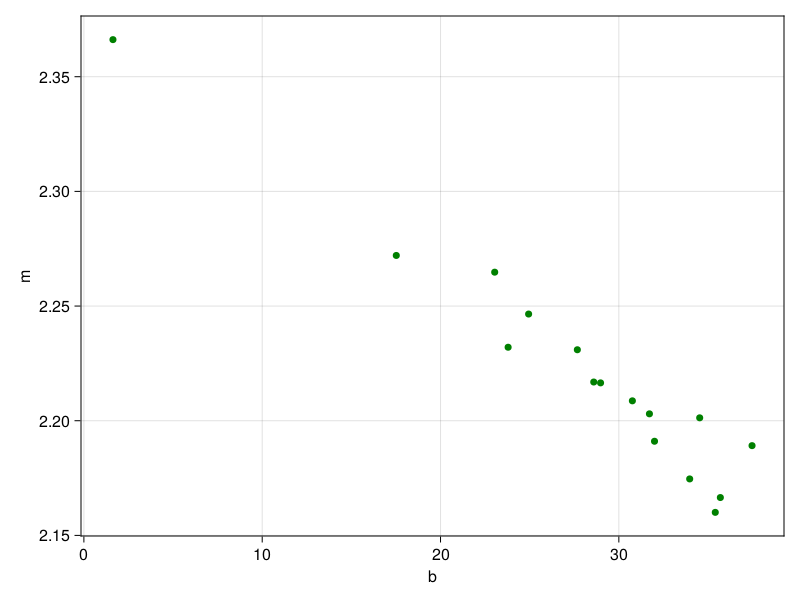

In [77]:
f = Figure()
Axis(f[1,1],xlabel = "b", ylabel = "m")
scatter!(B_jackr .- M_jackr.*mx, M_jackr, markersize=10, color=:green) 

f

Which is the same picture as before the reparametrization!

I asked some questions to Sercan about this project as well as to Dustin. I also used some parts of Dustin's code that we developed in the class and tutorial. As base I used the file we created in the class. 